In [138]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
import pykrige
from sklearn.neighbors import BallTree
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")


# Load the regional data 

We have a geojson file with the multipolygon containing our region

In [139]:
regions=gpd.read_file("data/NUTS_regions/NUTS_RG_01M_2021_4326.geojson")
region_BE=regions.loc[regions['CNTR_CODE']=="BE"]
region_VL=region_BE.loc[region_BE['NAME_LATN']=="Vlaams Gewest"]
region_VL.head()

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
56,BE2,BE2,1,BE,Vlaams Gewest,Vlaams Gewest,0.0,0,0,BE2,"MULTIPOLYGON (((5.89207 50.75524, 5.89101 50.7..."


*In a Point geometry, the coordinates are given as (longitude, latitude) in that order, whereas in geopy (and many other libraries), the coordinates are given as (latitude, longitude) in that order. So when creating a Point object from a set of coordinates, make sure to use the correct order.*

# Get the coordinates

In [140]:
import pandas as pd

df=pd.read_csv('./data/property_data.csv')

In [141]:
df =df [['id','latitude','longitude']] 
df = df[(df['latitude'] != 0) & (df['longitude'] >0)]

df

,id,latitude,longitude
0,3617717,50.888495,5.165747
1,5055347,50.442333,4.795752
4,5996820,50.411334,3.908516
5,5996885,50.411334,3.908516
6,5997015,50.411334,3.908516
...,...,...,...
80371,10132103,51.089034,5.073670
80372,10132881,50.962537,4.072612
80373,10138005,51.054914,4.980625
80374,10132109,51.132788,3.679074


In [142]:
latitudes = df['latitude'].tolist()
longitudes = df['longitude'].tolist()
coordinates = list(zip(longitudes, latitudes))

In [143]:

def write_to_csv(df): 
    df.to_csv(os.path.join("data","mobiscore_data.csv"),mode='w', header=True, lineterminator='', index=True)
    

# CRS conversion
To lookup the mobiscore from coordinates in the USW84 projection system we need to convert them to the Belgian Lambert 72 CRS.

In [144]:
def conv_to_lambert(df):
    from pyproj import Transformer 

    transformer = Transformer.from_crs("epsg:4326", "epsg:31370")

    df['lambert_latitude']=0
    df['lambert_longitude']=0

    for id in df['id']:
        if df['latitude'][df['id']==id].values[0]!=0:

            coords_1 = (df['latitude'][df['id']==id].values[0],df['longitude'][df['id']==id].values[0] )
            #print (coords_1)
            Lambert_x= transformer.transform(coords_1[0], coords_1[1])
            #print (Lambert_x)
            df.loc[df['id']==id, 'lambert_longitude'] = Lambert_x[0]
            df.loc[df['id']==id, 'lambert_latitude'] = Lambert_x[1] 
    write_to_csv(df)

# Extract mobiscores from a geoTIFF file
With this function we read the geoTIFF data using rasterio

In [145]:
# Function to generate mobiscores (Parallel)
from joblib import Parallel, delayed
import rasterio

def generate_mobiscore_parallel(n):
    dat = rasterio.open(r"data/ni_mobiscore_ha.tif")
    # read all the data from the first band
    z = dat.read()[0]

    def getval(lon, lat):
        idx = dat.index(lon, lat)    
        return dat.xy(*idx), z[idx]
 
    # Select 10.000 rows per job
    df_parallel=df[(n-1)*10000:(n)*10000]
    df_parallel["mobiscore"]=0

    for id in df_parallel['id']:

        # Must have longitude and latitude in data
        if df_parallel['latitude'][df_parallel['id']==id].values[0]!=0:

            # Must be in range of mobiscore chart 
            if (df_parallel['lambert_longitude'][df_parallel['id']==id].values[0]>22002)\
            &(df_parallel['lambert_longitude'][df_parallel['id']==id].values[0]<259000)\
            &(df_parallel['lambert_latitude'][df_parallel['id']==id].values[0]>153000)\
            &(df_parallel['lambert_latitude'][df_parallel['id']==id].values[0]<244999):
            
                df_parallel['mobiscore'][df_parallel['id']==id]=getval(df_parallel['lambert_longitude'][df_parallel['id']==id],df_parallel['lambert_latitude'][df_parallel['id']==id])[1]
 
    return df_parallel
            
def get_mobiscore_parallel(n_jobs): 

    # Create list of dataframes from function
    delayed_funcs = [delayed(generate_mobiscore_parallel)(n) for n in range (1,n_jobs+1)]
    parallel_pool = Parallel(n_jobs=n_jobs)
    rows_to_write=parallel_pool(delayed_funcs)

    # Combine the dataframes in the list to one df
    frames=[]
    for x in range (n_jobs):
        frames.append(rows_to_write[x])
    df_to_write = pd.concat(frames)

    # Write the dataframe including mobiscores
    write_to_csv(df_to_write)
    print (f"All mobiscores succesfully written..") 

In [146]:
# Generate mobiscore?

init=0

if init==1: 
    conv_to_lambert(df)
    get_mobiscore_parallel(9)

Obtain the mobiscore for properties for sale in Flanders

In [147]:
mobis_re=pd.read_csv("data/mobiscore_data.csv") 

# Remove some Null values
mobis_re.dropna(subset=['mobiscore'],inplace=True)

points = [Point(x, y) for x, y in zip(mobis_re['longitude'], mobis_re['latitude'])]

# Create a geopandas GeoDataFrame with the 'geometry' column set to the points
gdf = gpd.GeoDataFrame(mobis_re, geometry=points) 
gdf.crs = "epsg:4326"

# Perform the spatial join
points_within_multipolygon = gpd.sjoin(gdf, region_VL, how='inner')

mobis_re_vl=points_within_multipolygon
print ('Number of coordinates :' , len (mobis_re_vl))

Number of coordinates : 42559


### Create coordinates 
From these coordinates we will reconstruct the map

In [148]:
re_x=mobis_re_vl['longitude']
re_y=mobis_re_vl['latitude'] 

df_mobis = gpd.GeoDataFrame(
    mobis_re_vl, geometry=gpd.points_from_xy(re_x, re_y))

In [149]:
mobiscores=mobis_re_vl['mobiscore'] 

In [150]:

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('distance', ['red', 'yellow', 'green'])
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores]

### Create the colormap
We will try to simulate the original colormap in the mobiscore geotiff file.

In [151]:

color_palette=np.array([(215,24,29), (238,248,185), (41,130,185)])
color_palette=color_palette/255
cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette)
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
norm = plt.Normalize(vmin=0, vmax=10)
colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

### Plot the coordinates

Text(0.5, 112.44920053595531, 'longitude')

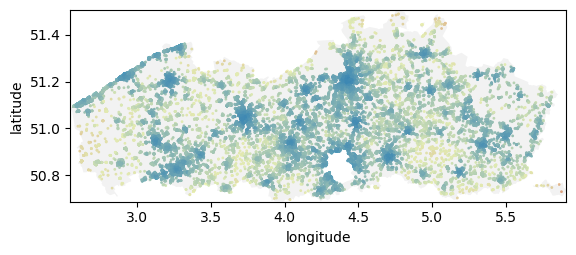

In [152]:
fig, ax = plt.subplots()

bounds=region_VL.total_bounds
plt.scatter(x=re_x,y=re_y,c=colors,s=1)
region_VL.plot(ax=ax,alpha=0.1,color='gray')
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')

# Create a grid

We will create a grid in Cartesian coordinates. This means that we calculate points with a fixed distance from eachother. 

First we set the grid resolution

In [153]:
sqr_km_area=2

237.7319880333897 90.86965347295218
2.0 km 2.0 km


<Axes: >

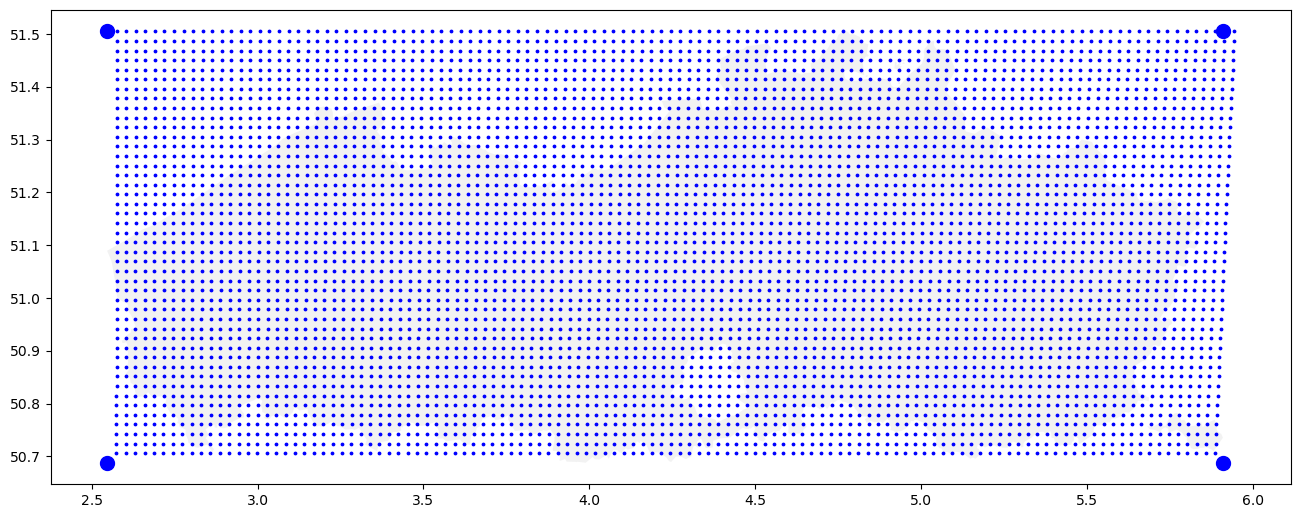

In [154]:
# Get the bounding box
bounds=region_VL.total_bounds # (latitude, longitude)

minx=bounds[0]
miny=bounds[1]
maxx=bounds[2]
maxy=bounds[3]

R1 = (bounds[3],bounds[2])  # Right Top
R2 = (bounds[1],bounds[2])  # Right Bottom

L1 = (bounds[3],bounds[0])  # Left Top
L2 = (bounds[1],bounds[0])  # Left Bottom

boundaries=[]

# Set the Point geometry (longitude, latitude)
L1_geopy=Point(bounds[0],bounds[3])
L2_geopy=Point(bounds[0],bounds[1])

R1_geopy=Point(bounds[2],bounds[3]) 
R2_geopy=Point(bounds[2],bounds[1])

boundaries.extend([L1_geopy,L2_geopy,R1_geopy,R2_geopy])

# Create a GeoDataFrame with a single row containing the point
df_boundaries = gpd.GeoDataFrame(geometry=boundaries, crs='epsg:4326')

max_longitude_distance = geopy.distance.distance(L2,R2).km 
max_latitude_distance= geopy.distance.distance(R1,R2).km

longitude_interval = geopy.distance.distance(kilometers=sqr_km_area)
latitude_interval = geopy.distance.distance(kilometers=sqr_km_area) 

# Print the max distances and intervals in metric units
print(max_longitude_distance, max_latitude_distance)
print(longitude_interval,latitude_interval)

grid=longitude_interval.km

# Calculate the number of points in longitude and latitude
n_longitude_grid_points= int (float(max_longitude_distance )/grid)
n_latitude_grid_points= int (float(max_latitude_distance)/grid)

# Calculate the interval in degrees
latitude_interval_degrees=(maxy-miny)/n_latitude_grid_points
longitude_interval_degrees=(maxx-minx)/n_longitude_grid_points
 
# Create a list of points
points = []

for j in range(n_latitude_grid_points):

    start = (bounds[3]-(j*latitude_interval_degrees),bounds[0])

    for i in range(n_longitude_grid_points):

        # Calculate the next point 100 meters away in the longitude direction 
        lon_offset = longitude_interval.destination(start, bearing=90).longitude - start[1]
        
        next_point = (start[0], start[1] + lon_offset)
        
        points.append(next_point)
        
        start = next_point

# Create a GeoDataFrame
points = [(point[1], point[0]) for point in points]
points= [Point(point) for point in points] 
grid = gpd.GeoDataFrame(geometry=points, crs='epsg:4326')

# Make the plot
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto') 

region_VL.plot(ax=ax,alpha=0.1,color='gray') 
grid.plot(ax=ax,markersize=3, color="blue")
df_boundaries.plot(ax=ax, color='blue', markersize=100)

## Spatial Join
Now we use sjoin to get a grid inside our region.

<Axes: >

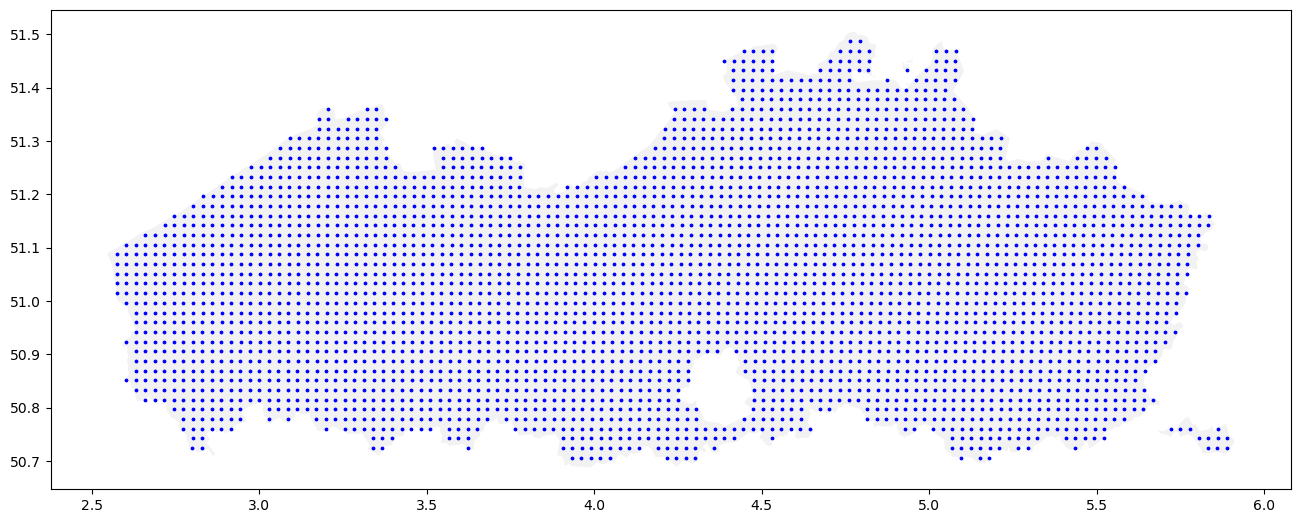

In [155]:
# Perform a spatial join between the two GeoDataFrames
joined = gpd.sjoin(grid, region_VL, how='inner')

# Keep only the points that are inside the multipolygon
points_within_regions = joined['geometry']

# Create a new GeoDataFrame with only the points that are inside the multipolygon
grid_within_regions = gpd.GeoDataFrame(geometry=points_within_regions, crs='epsg:4326')
 
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto') 

region_VL.plot(ax=ax,alpha=0.1,color='gray') 
grid_within_regions.plot(ax=ax,markersize=3, color="blue")
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)


### Save the grid to a shapefile

In [156]:
grid_within_regions.to_file(f'data/processed/mobiscore_grid_{sqr_km_area}km.shp')

### Using meshgrid and degrees

We could also use meshgrid to plot a grid with each point at fixed degrees from eachother. This is for demonstration purposes only.

<Axes: >

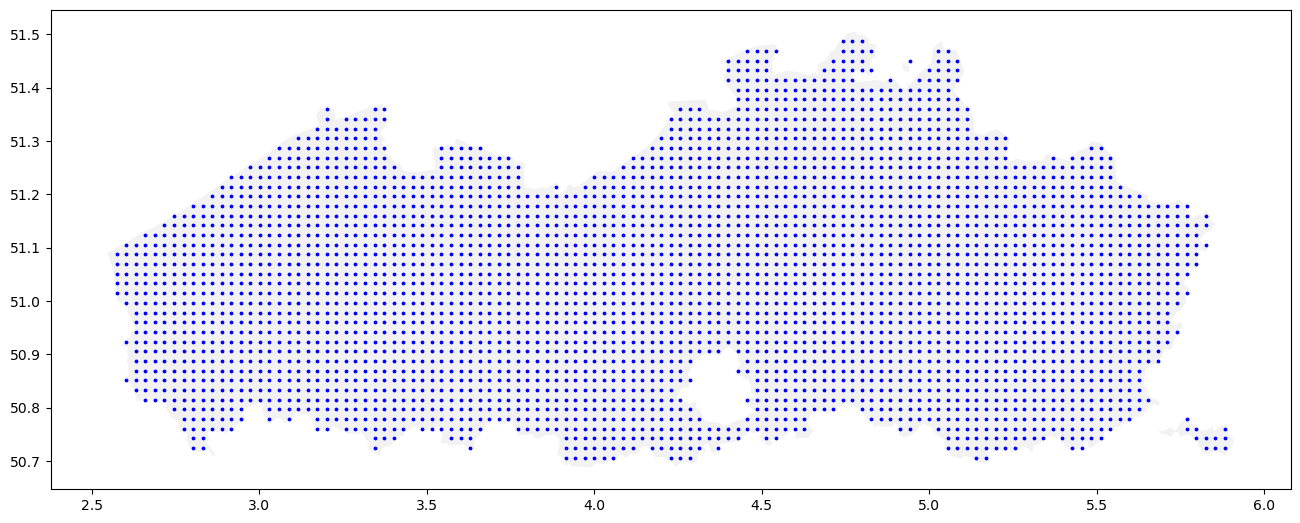

In [157]:
# n_latitude_grid_points: number of grid points in latitude direction
# n_longitude_grid_points: number of grid points in longitude direction
# minx, miny: minimum longitude and latitude values of the grid
# latitude_interval_degrees, longitude_interval_degrees: interval size in degrees

# Create a grid of latitude and longitude points
lats = np.linspace(miny, miny + (n_latitude_grid_points - 1) * latitude_interval_degrees, n_latitude_grid_points)
lons = np.linspace(minx, minx + (n_longitude_grid_points - 1) * longitude_interval_degrees, n_longitude_grid_points)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Flatten the arrays and create tuples of (longitude, latitude) pairs
lon_lat_pairs = np.column_stack((lon_grid.flatten(), lat_grid.flatten()))

# Convert the pairs to Point objects and create a GeoDataFrame with the points
points = [Point(lon, lat) for lon, lat in lon_lat_pairs]
grid = gpd.GeoDataFrame(geometry=points, crs='epsg:4326')

# Perform a spatial join between the two GeoDataFrames
joined = gpd.sjoin(grid, region_VL, how='inner')

# Keep only the points that are inside the multipolygon
points_within_regions = joined['geometry']

# Create a new GeoDataFrame with only the points that are inside the multipolygon
grid_within_regions = gpd.GeoDataFrame(geometry=points_within_regions, crs='epsg:4326')
 
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto') 

region_VL.plot(ax=ax,alpha=0.1,color='gray') 
grid_within_regions.plot(ax=ax,markersize=3, color="blue")
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)


## Assigning weights to the grid
Using balltree we assign the mobiscore of the closest property to each point in the grid.



In [158]:
# Load the grid for a set resolution
grid_within_regions=gpd.read_file(f'data/processed/mobiscore_grid_1km.shp')

# Set the resolution of the grid here
sqr_km_area=1

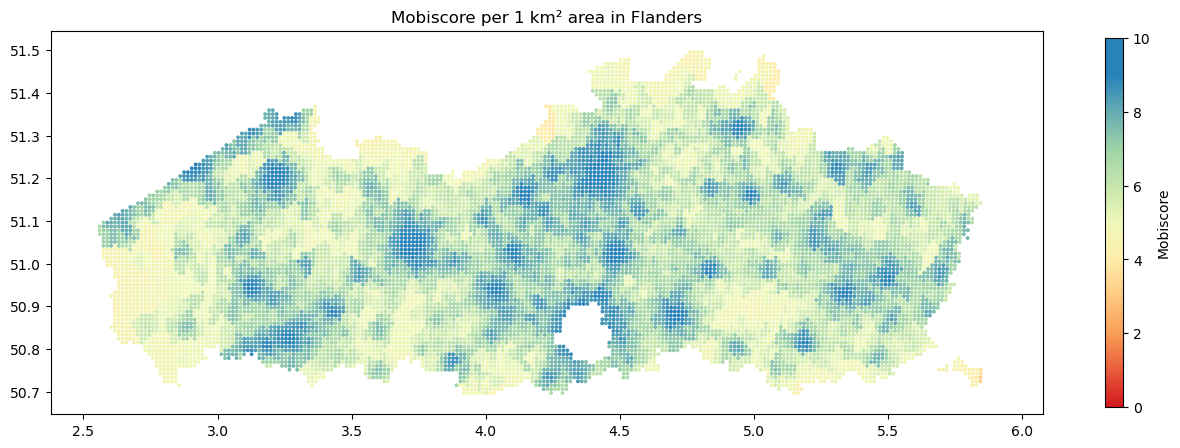

In [159]:
# Create a BallTree
tree = BallTree(df_mobis['geometry'].apply(lambda p: [p.x, p.y]).tolist(), leaf_size=2)

# Query the BallTree on each point in 'grid_within_regions' to find the id and distance to the nearest point in 'df_mobis'
distances, indices = tree.query(
    grid_within_regions['geometry'].apply(lambda p: [p.x, p.y]).tolist(), # The input array for the query
    k=1, # The number of nearest neighbors
)

# Calculate the mean distance and round the mean index for each point
grid_within_regions['distance_nearest'] = distances
grid_within_regions['id_nearest'] = indices

# Assign the closest mobiscore to the corresponding grid centroid
grid_within_regions['mobi_value']=df_mobis.iloc[grid_within_regions['id_nearest']]['mobiscore'].values 
mobiscores=grid_within_regions['mobi_value']

# Convert geometry points to separate lists of x and y coordinates
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]

# Create a colormap from the mobiscore values
color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])
color_palette=color_palette/255

cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette)
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
norm = plt.Normalize(vmin=0, vmax=10)

colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

# Plot the map
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto') 

# Use scatter function instead of plot function
ax.scatter(x=x_coords, y=y_coords, c=colors, s=3)   

# Set boundaries on the map for consistency 
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)

ax.set_title(f'Mobiscore per {sqr_km_area} km² area in Flanders')
 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Mobiscore')

## Interpolation using 5 neighbours 

Let's rewrite the BallTree code to calculate the weights using IDW and KNN.

In [160]:
# Load the grid for a set resolution
grid_within_regions=gpd.read_file(f'data/processed/mobiscore_grid_1km.shp')

# Set the resolution of the grid here
sqr_km_area=1

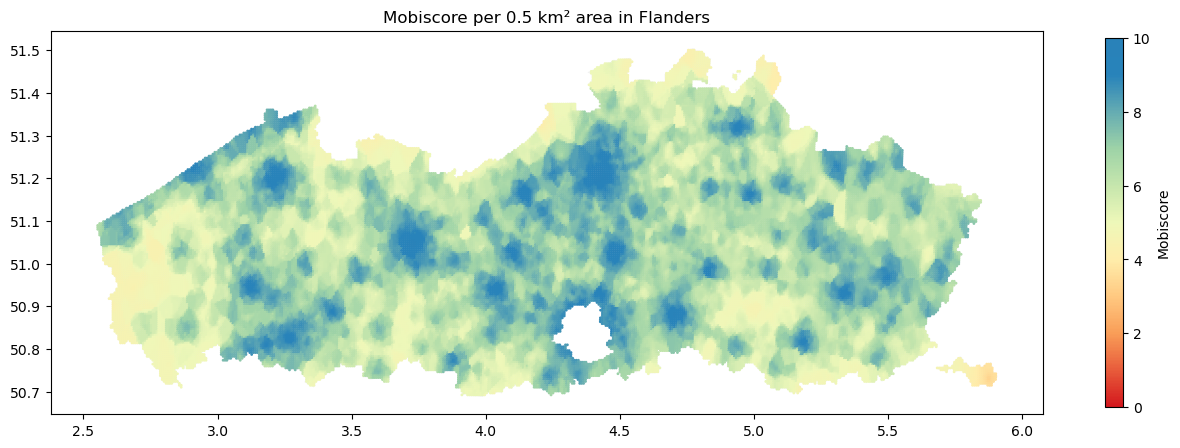

In [161]:
# Create a BallTree
tree = BallTree(df_mobis['geometry'].apply(lambda p: [p.x, p.y]).tolist(), leaf_size=2)

# Query the BallTree on each feature from 'grid_within_regions' to find the distance
# to the nearest point in 'df_mobis' and its id
distances, indices = tree.query(
    grid_within_regions['geometry'].apply(lambda p: [p.x, p.y]).tolist(), # The input array for the query
    k=5, # The number of nearest neighbors
)

mobiscore_array = np.array([[df_mobis['mobiscore'].iloc[idx] for idx in row] for row in indices])

# Calculate the reciprocal of the distances
weights = 1 / distances

# Calculate the sum of the weights 
row_sum = np.sum(weights, axis=1).reshape(-1, 1)

# Normalize each row 
normalized_weights = weights / row_sum

# Multiply the mobiscores by the corresponding weights
weighted_mobiscores = normalized_weights * mobiscore_array

# Sum the weighted inverse distances
sum_weighted_mobiscores = np.sum(weighted_mobiscores, axis=1) 
idw_average = sum_weighted_mobiscores

grid_within_regions['IDW_mobiscore']=idw_average 
mobiscores=grid_within_regions['IDW_mobiscore']

# Convert geometry points to separate lists of x and y coordinates
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]

# Create a colormap from the mobiscore values 
color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])
color_palette=color_palette/255

cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette)
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
norm = plt.Normalize(vmin=0, vmax=10)

colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto')
region_VL.plot(ax=ax,alpha=0.1,color='gray') 

# Use scatter function instead of plot function
ax.scatter(x=x_coords, y=y_coords, c=colors, s=1)   

#grid_within_regions.plot(ax=ax,markersize=3, c=colors )
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)

ax.set_title(f'Mobiscore per {sqr_km_area} km² area in Flanders')
 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Mobiscore')

## USING KNeighborsRegressor from sklearn

In [174]:
# Load the grid for a set resolution
grid_within_regions=gpd.read_file(f'data/processed/mobiscore_grid_0.5km.shp')

# Set the resolution of the grid here
sqr_km_area=0.5

In [175]:
# Get property coordinates
re_x=mobis_re_vl['longitude']
re_y=mobis_re_vl['latitude'] 

# Make a list of the coordinates
points=  list(zip(re_x, re_y))

# Make a list of the weights
weights= df_mobis['mobiscore'] 

# Extract the grid coordinates from our GeoDataFrame
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]
 
# Make a list of the grid coordinates
grid_points=list(zip(x_coords, y_coords)) 


In [176]:
#Function to create the inverse distance weighting

def idw_weights(distances):
    # Set the power parameter for IDW (e.g., 2)
    power = 2
    # Calculate the IDW weights based on distances
    with np.errstate(divide='ignore', invalid='ignore'):
        weights = 1.0 / distances ** power
    return weights

In [177]:
# Create a KNeighborsRegressor instance 
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights=idw_weights)

# Fit the KNeighborsRegressor to the input points and weights
knn_regressor.fit(points, weights)

# Perform KNN interpolation
interpolated_weights = knn_regressor.predict(grid_points)
mobiscores=interpolated_weights


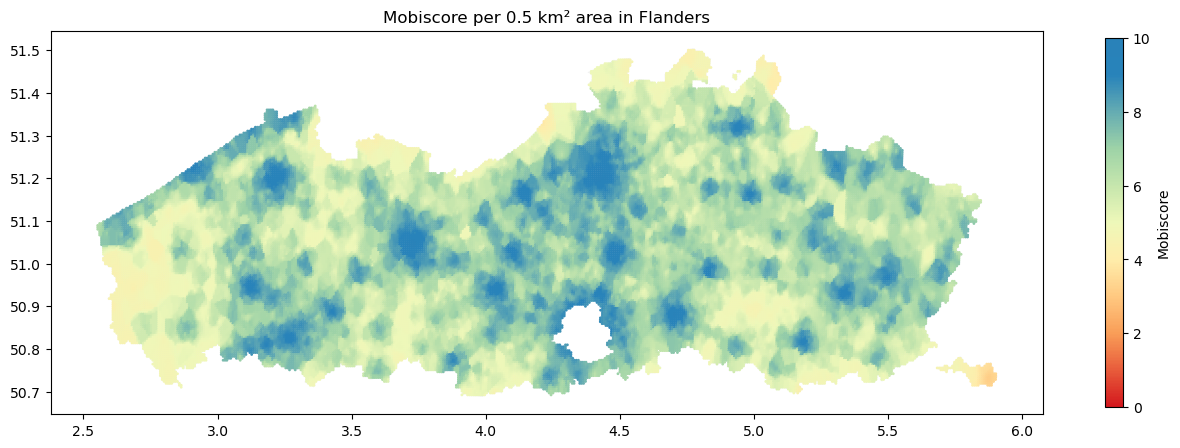

In [179]:
# Create the colormap
from matplotlib.colors import LinearSegmentedColormap

color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])
color_palette=color_palette/255

cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette)
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
norm = plt.Normalize(vmin=0, vmax=10)

colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

# Create the plot
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto')

region_VL.plot(ax=ax,alpha=0.1,color='gray') 

# Convert geometry points to separate lists of x and y coordinates
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]

# Use scatter function instead of plot function
ax.scatter(x=x_coords, y=y_coords, c=colors, s=1)   

#grid_within_regions.plot(ax=ax,markersize=3, c=colors )
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)

ax.set_title(f'Mobiscore per {sqr_km_area} km² area in Flanders')
 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Mobiscore')

## Try the same with griddata

In [167]:
grid_within_regions=gpd.read_file(f'data/processed/mobiscore_grid_1km.shp')

In [168]:
re_x=mobis_re_vl['longitude']
re_y=mobis_re_vl['latitude'] 
mobiscores=mobis_re_vl['mobiscore']

# Extract x and y coordinates from the POINT geometries
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]

# Combine the x and y coordinates into a numpy array
grid_coordinates = np.column_stack((x_coords, y_coords))

from scipy.interpolate import griddata

# Create numpy arrays
points = np.vstack((re_x, re_y)).T 
weights=mobis_re_vl['mobiscore'].to_numpy()  
# Set the method 
interpolated_weights = griddata(points, weights, grid_coordinates, method='linear') 

# Create a new GeoDataFrame with the interpolated weights
grid_interpolated = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in grid_coordinates], crs='epsg:4326')
grid_interpolated['interpolated_weights'] = interpolated_weights 

In [169]:
grid_within_regions

,distance_n,id_nearest,mobi_value,geometry
0,0.012285,18222,4.708811,POINT (3.91890 50.69711)
1,0.005499,18222,4.708811,POINT (3.93306 50.69711)
2,0.007199,17322,4.758586,POINT (3.94721 50.69711)
3,0.018205,17322,4.758586,POINT (3.96136 50.69711)
4,0.031806,17322,4.758586,POINT (3.97552 50.69711)
...,...,...,...,...
13447,0.019839,2163,4.301525,POINT (5.03663 51.48669)
13448,0.010912,22295,4.260730,POINT (4.76353 51.49576)
13449,0.009086,26819,4.379495,POINT (4.77793 51.49576)
13450,0.020975,26819,4.379495,POINT (4.79233 51.49576)


In [170]:
color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])
color_palette=color_palette/255
cmap = LinearSegmentedColormap.from_list('interpolated_weights', color_palette)
 
norm = plt.Normalize(vmin=min(interpolated_weights), vmax=max(interpolated_weights))
norm = plt.Normalize(vmin=0, vmax=10)
colors = [cmap(norm(weight)) for weight in interpolated_weights] 

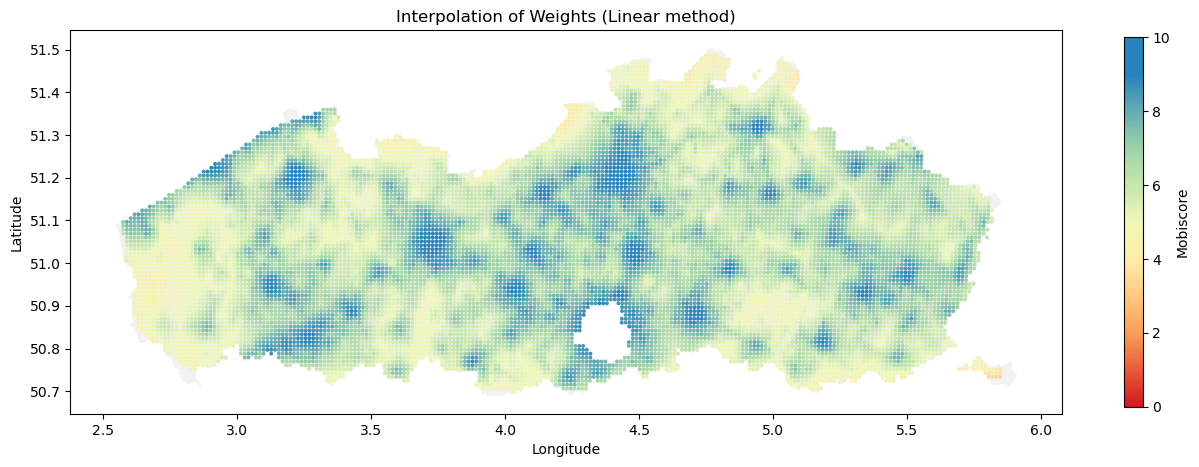

In [171]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
ax.set_aspect('auto')
#grid_interpolated.plot(column='interpolated_weights',c=colors, ax=ax, markersize=2, legend=True)

# Extract x and y coordinates from the POINT geometries
x_coords = [pt.x for pt in grid_interpolated.geometry]
y_coords = [pt.y for pt in grid_interpolated.geometry]

region_VL.plot(ax=ax,alpha=0.1,color='gray') 
# Use ax.scatter instead of grid_interpolated.plot
ax.scatter(x_coords, y_coords, c=colors, s=3)
df_boundaries.plot(ax=ax, color='blue', markersize=100, alpha=0)
           
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Mobiscore')

plt.title('Interpolation of Weights (Linear method)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

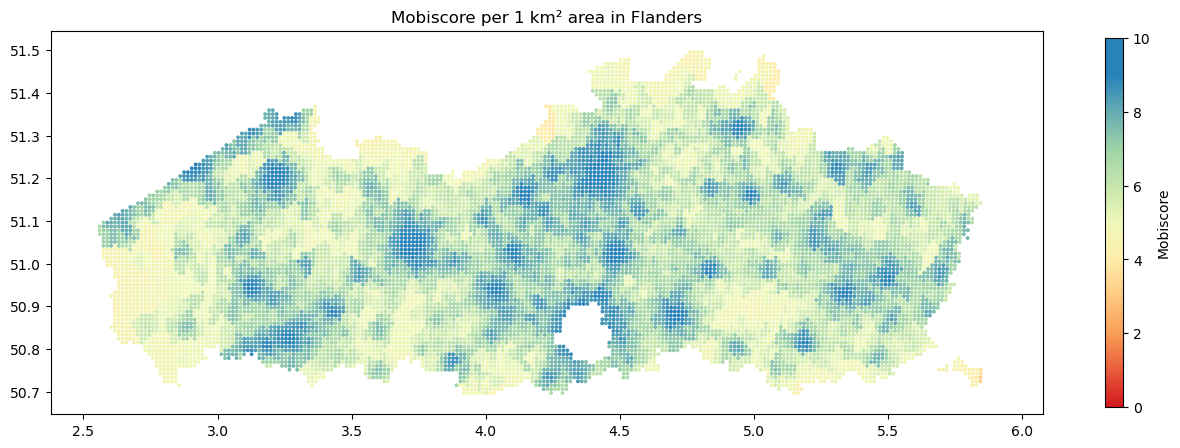

In [172]:
grid_within_region=gpd.read_file(f'data/processed/mobiscore_grid_1km.shp')
sqr_km_area=1

mobiscores=grid_within_regions['mobi_value']

from matplotlib.colors import LinearSegmentedColormap
 
color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])

color_palette=color_palette/255

cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette) 
norm = plt.Normalize(vmin=0, vmax=10)
colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto')
#plt.scatter(x=re_x,y=re_y,c=colors)
#region_VL.plot(ax=ax,alpha=0.1,color='blue') 

# Convert geometry points to separate lists of x and y coordinates
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]

# Use scatter function instead of plot function
ax.scatter(x=x_coords, y=y_coords, c=colors, s=3)  

#grid_within_regions.plot(ax=ax,markersize=3, c=colors )
df_boundaries.plot(ax=ax, color='blue', markersize=100,alpha=0)

ax.set_title(f'Mobiscore per {sqr_km_area} km² area in Flanders')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.3)
cbar.set_label('Mobiscore')

<Axes: title={'center': 'Properties for sale and their mobiscore'}>

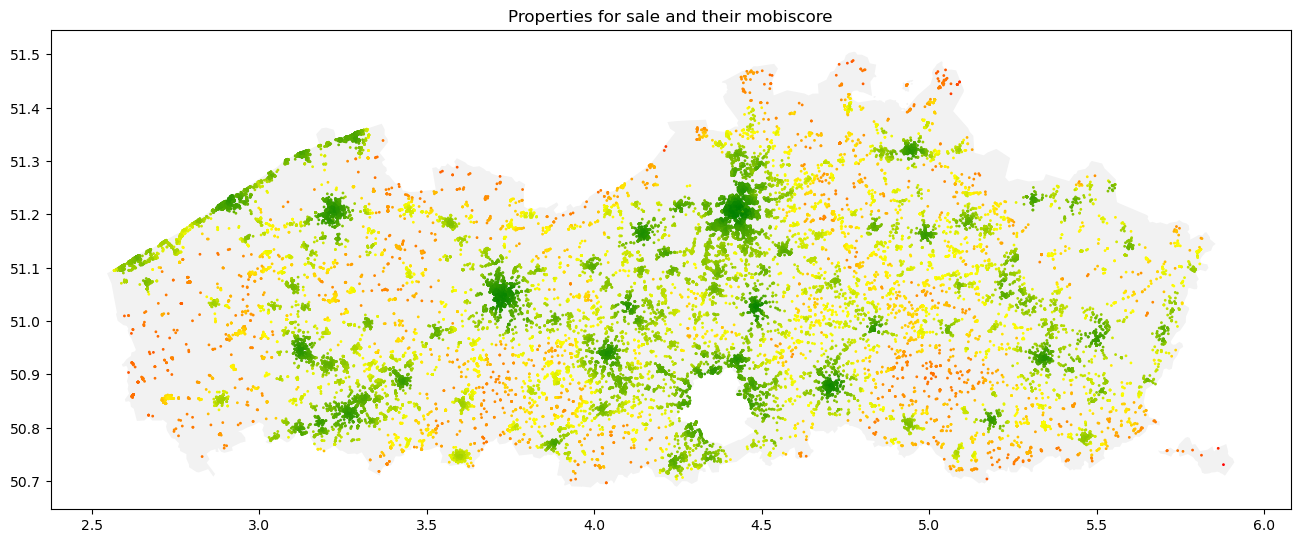

In [173]:
# Create the plot for the real estate points

re_x=mobis_re_vl['longitude']
re_y=mobis_re_vl['latitude'] 

df_mobis = gpd.GeoDataFrame(
    mobis_re_vl, geometry=gpd.points_from_xy(re_x, re_y))

mobiscores=mobis_re_vl['mobiscore']

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('distance', ['red', 'yellow', 'green'])
norm = plt.Normalize(vmin=min(mobiscores), vmax=max(mobiscores))
colors_RYG = [cmap(norm(mobiscore)) for mobiscore in mobiscores]

grid_within_region=gpd.read_file(f'data/processed/mobiscore_grid_1km.shp')
sqr_km_area=5

mobiscores=grid_within_regions['mobi_value']

from matplotlib.colors import LinearSegmentedColormap
color_palette=np.array([(211,23,29),(232,92,59),(249,158,88),(255,201,129),(255,237,171),(238,248,185),(198,230,173),(158,211,167),(101,172,178),(40,131,186),(41,130,185)])

color_palette=color_palette/255

cmap = LinearSegmentedColormap.from_list('mobiscore', color_palette) 
norm = plt.Normalize(vmin=0, vmax=10)
colors = [cmap(norm(mobiscore)) for mobiscore in mobiscores] 

fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('auto')
ax.set_title('Properties for sale and their mobiscore');
region_VL.plot(ax=ax,alpha=0.1,color='gray') 

# Convert geometry points to separate lists of x and y coordinates
x_coords = [pt.x for pt in grid_within_regions.geometry]
y_coords = [pt.y for pt in grid_within_regions.geometry]
 
plt.scatter(x=re_x,y=re_y,c=colors_RYG,s=1) 
df_boundaries.plot(ax=ax, color='blue', markersize=100,alpha=0)


In [ ]:

#!/usr/bin/env python
# coding: utf-8

# In[6]:


#rounding coordinates by chosen precision creates a grid
rounding_num=0.015 
df["lon_mod"]=np.round(df.longitude/rounding_num,0)*rounding_num

#adjusting for difference in actual distance between same numeric change in lat and lon to create a square grid
correction_coeff=0.5
df["lat_mod"]=np.round(df.latitude/(rounding_num*correction_coeff),0)*(rounding_num*correction_coeff)

df_map=df[["lat_mod","lon_mod","unit_price"]].groupby(["lat_mod","lon_mod"], as_index=False).mean()

df_map.head()